# **Importações e Montagem do Google Drive**

- Importa bibliotecas essenciais para manipulação de dados, processamento de imagens, criação e treinamento de redes neurais.
- Monta o Google Drive para acessar arquivos armazenados na nuvem, como datasets ou modelos pré-treinados.

**Bibliotecas Importadas**:
- **google.colab.drive**: Para montar o Google Drive no Colab.
- **numpy**: Manipulação eficiente de arrays e operações matemáticas.
- **pandas**: Análise e manipulação de dados.
- **os**: Interação com o sistema operacional.
- **cv2 (OpenCV)**: Manipulação e processamento de imagens.
- **matplotlib.pyplot**: Visualização de dados e plotagem de gráficos.
- **keras**: Construção e treinamento de redes neurais.
- **tensorflow**: Framework de deep learning.
- **sklearn.model_selection**: Divisão de dados em conjuntos de treinamento e teste.
- **numpy.random.seed** e **tensorflow.random.set_seed**: Garantir a reprodutibilidade dos resultados.

O uso de `tf.random.set_seed(123)` garante que as operações aleatórias sejam reproduzíveis, o que é importante para comparar experimentos.

In [27]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [28]:
import numpy as np
import pandas as pd
import os
import cv2 as cv
import matplotlib.pyplot as plt
from keras.applications import vgg16
from keras.models import Model, load_model
import keras
from keras.layers import Input, Conv2D, Conv2DTranspose, AveragePooling2D, MaxPooling2D, UpSampling2D, LeakyReLU, concatenate, Dropout, BatchNormalization, Activation
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.optimizers import Adam
from sklearn.model_selection import train_test_split
from numpy.random import seed
import tensorflow as tf
import time
from keras import backend as K


tf.random.set_seed(123)



---

# **Carregamento e Visualização Inicial dos Dados**

- Carrega as imagens de um arquivo `.h5` e as armazena em arrays `X_data` e `Y_data`.
- Visualiza as primeiras 5 imagens e suas respectivas máscaras para garantir que os dados foram carregados corretamente.

**Bibliotecas Utilizadas**:
- **h5py**: Para abrir e manipular arquivos no formato HDF5, ideal para armazenar grandes volumes de dados.
- **matplotlib.pyplot**: Para plotar as imagens e as máscaras correspondentes.

**Motivação**:
- A visualização inicial é crucial para verificar a integridade e a qualidade dos dados antes de iniciar o treinamento do modelo.



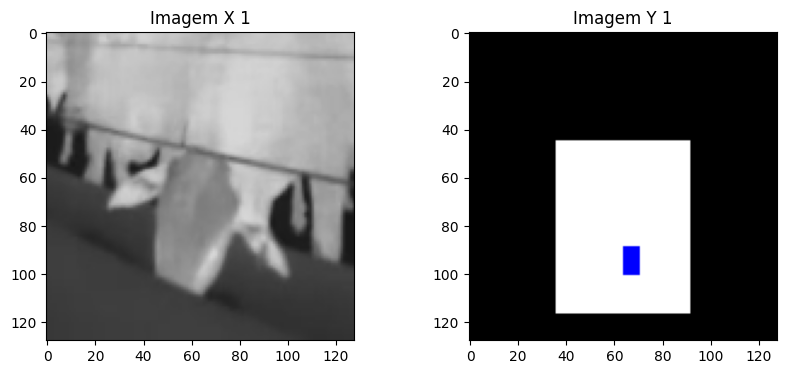

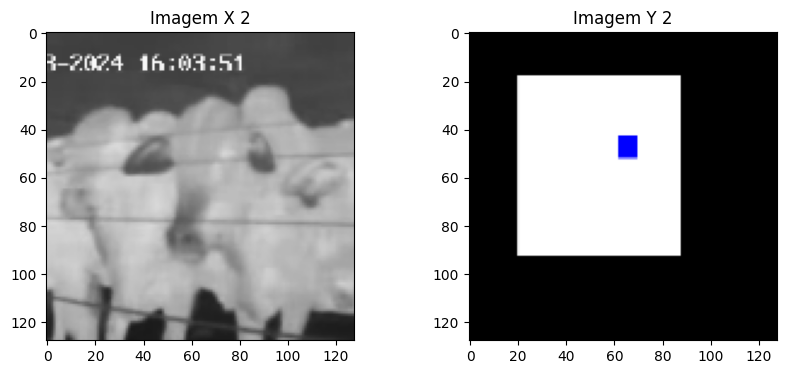

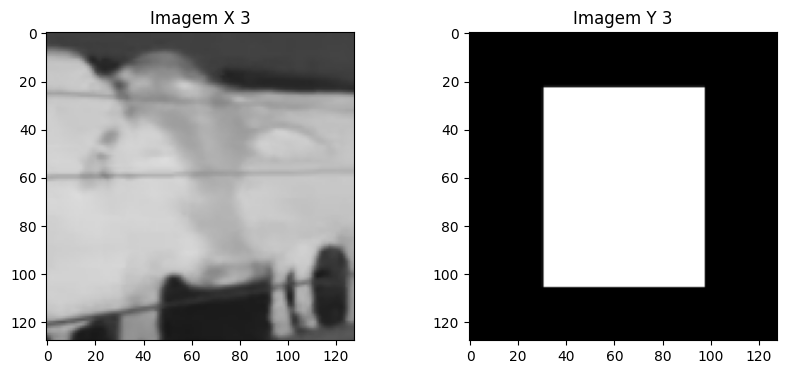

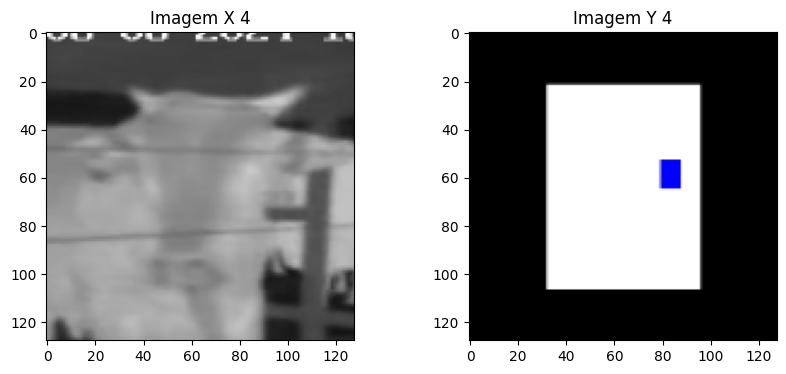

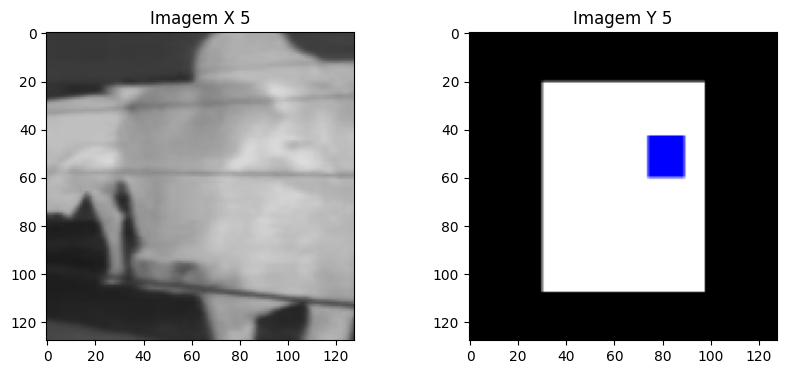

In [29]:
import h5py
import matplotlib.pyplot as plt
import numpy as np

# Abrindo o arquivo .h5
with h5py.File('/content/drive/MyDrive/data/combined_data.h5', 'r') as h5f:
    # Carregando as imagens X e Y
    X_data = h5f['X'][:]
    Y_data = h5f['Y'][:]

# Exibindo algumas imagens
for i in range(5):  # Mostrando as primeiras 5 imagens
    plt.figure(figsize=(10, 4))
    # Plotando a imagem X
    plt.subplot(1, 2, 1)
    plt.imshow(X_data[i])
    plt.title(f'Imagem X {i+1}')
    # Plotando a imagem Y
    plt.subplot(1, 2, 2)
    plt.imshow(Y_data[i])
    plt.title(f'Imagem Y {i+1}')
    plt.show()


In [30]:
print(len(X_data))
print(len(Y_data))

2440
2440


# **Preparação dos Dados e Definição de Parâmetros do Modelo**

- Define as variáveis `X_` e `y_` para armazenar os dados de entrada e saída, respectivamente.
- Obtém e imprime as formas dos dados (`shape_X` e `shape_y`) para garantir que os dados estão no formato esperado.
- Define o `input_shape` necessário para a rede neural baseada no modelo VGG16.
- Carrega o modelo pré-treinado VGG16, que será usado como base para o modelo de segmentação.

**Motivação**:
- Garantir que os dados estejam no formato correto antes de serem passados para o modelo.
- Utilizar um modelo pré-treinado (VGG16) permite aproveitar o conhecimento aprendido em uma tarefa de grande escala (ImageNet), acelerando o treinamento e melhorando o desempenho do modelo em novas tarefas.


In [31]:
X_ = X_data
y_ = Y_data


In [32]:
shape_X = X_.shape
shape_y = y_.shape

print(f"A forma de X_ é: {shape_X}")
print(f"A forma de y_ é: {shape_y}")

A forma de X_ é: (2440, 128, 128, 3)
A forma de y_ é: (2440, 128, 128, 3)


In [33]:
input_shape = (128, 128, 3)
VGG16 = vgg16.VGG16(include_top=False, weights='imagenet', input_shape=input_shape)
print('Model loaded.')

Model loaded.


In [34]:
output_ = VGG16.output
output_

<KerasTensor: shape=(None, 4, 4, 512) dtype=float32 (created by layer 'block5_pool')>

# **Definição de Camadas Treináveis e Não Treináveis**

- Define quais camadas do modelo VGG16 serão treináveis, permitindo ajustar a rede (fine-tuning) para a nova tarefa de segmentação.
- Constrói um novo modelo a partir das camadas selecionadas do VGG16.

**Motivação**:
- Manter as primeiras camadas da VGG16 congeladas (não treináveis) preserva os recursos básicos aprendidos durante o treinamento no ImageNet.
- Descongelar camadas mais profundas permite ajustar a rede para a nova tarefa específica, como segmentação de imagens.


In [35]:
set_trainable = False
for layer in VGG16.layers:
    if layer.name in ['block1_conv1']:
        set_trainable = True
    if layer.name in ['block1_pool','block2_pool','block3_pool','block4_pool','block5_pool']:
        layer.trainable = False

In [36]:
vgg_model = Model(VGG16.input, output_)
layers = [(layer, layer.name, layer.trainable) for layer in vgg_model.layers]
pd.DataFrame(layers, columns=['Layer Type', 'Layer Name', 'Layer Trainable'])

,Layer Type,Layer Name,Layer Trainable
0,<keras.src.engine.input_layer.InputLayer objec...,input_4,True
1,<keras.src.layers.convolutional.conv2d.Conv2D ...,block1_conv1,True
2,<keras.src.layers.convolutional.conv2d.Conv2D ...,block1_conv2,True
3,<keras.src.layers.pooling.max_pooling2d.MaxPoo...,block1_pool,False
4,<keras.src.layers.convolutional.conv2d.Conv2D ...,block2_conv1,True
5,<keras.src.layers.convolutional.conv2d.Conv2D ...,block2_conv2,True
6,<keras.src.layers.pooling.max_pooling2d.MaxPoo...,block2_pool,False
7,<keras.src.layers.convolutional.conv2d.Conv2D ...,block3_conv1,True
8,<keras.src.layers.convolutional.conv2d.Conv2D ...,block3_conv2,True
9,<keras.src.layers.convolutional.conv2d.Conv2D ...,block3_conv3,True


In [37]:
vgg_model.summary()

Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 128, 128, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 128, 128, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 128, 128, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 64, 64, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 64, 64, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 64, 64, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 32, 32, 128)       0   

# **Construção do Modelo Personalizado**

- Constrói um modelo de rede neural personalizada combinando a VGG16 com camadas adicionais de convolução e transposição de convolução.
- As camadas de `Conv2DTranspose` e `LeakyReLU` são usadas para aumentar a resolução espacial e aplicar funções de ativação.
- A função `ModelEnhancer` é responsável por construir e retornar o modelo final.

**Motivação**:
- A arquitetura U-Net, combinada com VGG16, é ideal para tarefas de segmentação, permitindo que o modelo recupere a resolução espacial necessária para prever máscaras de segmentação precisas.
- O uso de `Conv2DTranspose` é essencial para aumentar a resolução da imagem durante a decodificação.


In [38]:
import tensorflow as tf
from tensorflow.keras.layers import Conv2D, Conv2DTranspose, LeakyReLU, BatchNormalization, concatenate, Input
from tensorflow.keras.models import Model
from tensorflow.keras.applications import VGG16 as VGG16_model  # Renomeando para evitar conflito

def ModelEnhancer():
    input_shape = (128, 128, 3)
    VGG16_weight = 'imagenet'
    base_model = VGG16_model(include_top=False, weights=VGG16_weight, input_shape=input_shape)
    last_layer = base_model.output

    set_trainable = False
    for layer in base_model.layers:
        if layer.name in ['block1_conv1']:
            set_trainable = True
        if layer.name in ['block1_pool','block2_pool','block3_pool','block4_pool','block5_pool']:
            layer.trainable = False

    model_ = Conv2DTranspose(256, (3, 3), strides=(2, 2), padding='same')(last_layer)
    model_ = LeakyReLU(0.1)(model_)
    model_ = BatchNormalization()(model_)

    concat_1 = concatenate([model_, base_model.get_layer("block5_conv3").output])

    model_ = Conv2D(512, (3, 3), strides=(1, 1), padding='same')(concat_1)
    model_ = LeakyReLU(0.1)(model_)
    model_ = BatchNormalization()(model_)

    model_ = Conv2DTranspose(512, (3, 3), strides=(2, 2), padding='same')(model_)
    model_ = LeakyReLU(0.1)(model_)
    model_ = BatchNormalization()(model_)

    concat_2 = concatenate([model_, base_model.get_layer("block4_conv3").output])

    model_ = Conv2D(512, (3, 3), strides=(1, 1), padding='same')(concat_2)
    model_ = LeakyReLU(0.1)(model_)
    model_ = BatchNormalization()(model_)

    model_ = Conv2DTranspose(512, (3, 3), strides=(2, 2), padding='same')(model_)
    model_ = LeakyReLU(0.1)(model_)
    model_ = BatchNormalization()(model_)

    concat_3 = concatenate([model_, base_model.get_layer("block3_conv3").output])

    model_ = Conv2D(256, (3, 3), strides=(1, 1), padding='same')(concat_3)
    model_ = LeakyReLU(0.1)(model_)
    model_ = BatchNormalization()(model_)

    model_ = Conv2DTranspose(256, (3, 3), strides=(2, 2), padding='same')(model_)
    model_ = LeakyReLU(0.1)(model_)
    model_ = BatchNormalization()(model_)

    concat_4 = concatenate([model_, base_model.get_layer("block2_conv2").output])

    model_ = Conv2D(128, (3, 3), strides=(1, 1), padding='same')(concat_4)
    model_ = LeakyReLU(0.1)(model_)
    model_ = BatchNormalization()(model_)

    model_ = Conv2DTranspose(128, (3, 3), strides=(2, 2), padding='same')(model_)
    model_ = LeakyReLU(0.1)(model_)
    model_ = BatchNormalization()(model_)

    concat_5 = concatenate([model_, base_model.get_layer("block1_conv2").output])

    model_ = Conv2D(64, (3, 3), strides=(1, 1), padding='same')(concat_5)
    model_ = LeakyReLU(0.1)(model_)
    model_ = BatchNormalization()(model_)

    model_ = Conv2D(3, (3, 3), strides=(1, 1), padding='same')(model_)
    model_ = LeakyReLU(0.1)(model_)
    model_ = BatchNormalization()(model_)

    model_ = Model(base_model.input, model_)

    return model_

# Para usar o modelo
model = ModelEnhancer()
model.summary()


Model: "model_4"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_5 (InputLayer)        [(None, 128, 128, 3)]        0         []                            
                                                                                                  
 block1_conv1 (Conv2D)       (None, 128, 128, 64)         1792      ['input_5[0][0]']             
                                                                                                  
 block1_conv2 (Conv2D)       (None, 128, 128, 64)         36928     ['block1_conv1[0][0]']        
                                                                                                  
 block1_pool (MaxPooling2D)  (None, 64, 64, 64)           0         ['block1_conv2[0][0]']        
                                                                                            

In [39]:
Model_ = ModelEnhancer()
Model_.summary()

Model: "model_5"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_6 (InputLayer)        [(None, 128, 128, 3)]        0         []                            
                                                                                                  
 block1_conv1 (Conv2D)       (None, 128, 128, 64)         1792      ['input_6[0][0]']             
                                                                                                  
 block1_conv2 (Conv2D)       (None, 128, 128, 64)         36928     ['block1_conv1[0][0]']        
                                                                                                  
 block1_pool (MaxPooling2D)  (None, 64, 64, 64)           0         ['block1_conv2[0][0]']        
                                                                                            

# **Definição de Funções de Perda Personalizadas**

- Define várias funções de perda personalizadas como `jaccard_loss`, `focal_loss`, `weighted_loss`, `dice_loss`, e `cross_entropy_loss`.
- Essas funções de perda são essenciais para treinar o modelo de segmentação de maneira eficiente.

**Motivação**:
- As funções de perda personalizadas, como Dice Loss e Jaccard Loss, são particularmente úteis em tarefas de segmentação, onde há um desbalanceamento significativo entre as classes.
- Focal Loss é usada para focar em exemplos difíceis, ajudando o modelo a aprender de maneira mais eficaz em situações onde a maioria das previsões está correta.

### Jaccard Loss

In [40]:
import tensorflow as tf

@tf.keras.utils.register_keras_serializable()
def jaccard_loss(y_true, y_pred):
    y_true = tf.cast(y_true, tf.float32)
    y_pred = tf.cast(y_pred, tf.float32)

    intersection = tf.reduce_sum(y_true * y_pred)
    sum_ = tf.reduce_sum(y_true + y_pred)
    jac = (intersection + 1e-15) / (sum_ - intersection + 1e-15)

    return 1 - jac


### Focal Loss

In [41]:
import tensorflow as tf

@tf.keras.utils.register_keras_serializable()
def focal_loss(y_true, y_pred, alpha=0.25, gamma=2.0):
    y_true = tf.cast(y_true, tf.float32)
    y_pred = tf.cast(y_pred, tf.float32)

    # Clip predictions to prevent log(0)
    epsilon = tf.keras.backend.epsilon()
    y_pred = tf.clip_by_value(y_pred, epsilon, 1.0 - epsilon)

    # Compute the cross entropy term
    cross_entropy = -y_true * tf.math.log(y_pred)

    # Compute the focal loss factor
    focal_factor = alpha * tf.pow((1 - y_pred), gamma)

    # Compute focal loss
    loss = focal_factor * cross_entropy

    # Return the sum over the batch dimension
    return tf.reduce_sum(loss, axis=-1)


### Weighted Loss 

In [42]:
import tensorflow as tf

@tf.keras.utils.register_keras_serializable()
def weighted_loss(y_true, y_pred, weight_black=1.0, weight_white=1.0, weight_blue=1.0):
    # Separar os canais de y_true e y_pred
    red_channel_true = y_true[ :, :, 0]
    green_channel_true = y_true[ :, :, 1]
    blue_channel_true = y_true[ :, :, 2]

    red_channel_pred = y_pred[ :, :, 0]
    green_channel_pred = y_pred[ :, :, 1]
    blue_channel_pred = y_pred[ :, :, 2]

    # Criar máscaras para cada cor com base em y_true
    mask_black = tf.cast((red_channel_true == 0) & (green_channel_true == 0) & (blue_channel_true == 0), tf.float32)
    mask_white = tf.cast((red_channel_true == 255) & (green_channel_true == 255) & (blue_channel_true == 255), tf.float32)
    mask_blue = tf.cast((red_channel_true == 0) & (green_channel_true == 0) & (blue_channel_true == 255), tf.float32)

    # Garantir que y_pred esteja no intervalo [epsilon, 1 - epsilon]
    y_pred = tf.clip_by_value(y_pred, tf.keras.backend.epsilon(), 1 - tf.keras.backend.epsilon())

    # Calcular a perda ponderada para cada máscara
    loss_black = mask_black * (-tf.math.log(1 - y_pred)) * weight_black
    loss_white = mask_white * (-tf.math.log(1 - y_pred)) * weight_white
    loss_blue = mask_blue * (-tf.math.log(y_pred)) * weight_blue

    # Somar as perdas
    total_loss = loss_black + loss_white + loss_blue

    # Retornar a média da perda para todos os canais
    return tf.reduce_mean(total_loss)



### Binary Cross entropy

In [43]:
from tensorflow.keras.losses import BinaryCrossentropy
from tensorflow.keras.optimizers import Adam

# Instantiate the binary crossentropy loss function
binary_crossentropy = BinaryCrossentropy()


### Dice Loss

In [44]:
import tensorflow as tf

# Define the Dice Loss function
@tf.keras.utils.register_keras_serializable()
def dice_loss(y_true, y_pred, smooth=1e-6):
    y_true = tf.cast(y_true, tf.float32)
    y_pred = tf.cast(y_pred, tf.float32)

    intersection = tf.reduce_sum(y_true * y_pred)
    union = tf.reduce_sum(y_true) + tf.reduce_sum(y_pred)

    dice = (2. * intersection + smooth) / (union + smooth)
    return 1 - dice


### Cross Entropy

In [ ]:
import tensorflow as tf

@tf.keras.utils.register_keras_serializable()
def cross_entropy_loss(y_true, y_pred):
    y_true = tf.cast(y_true, tf.float32)
    y_pred = tf.cast(y_pred, tf.float32)
    loss = tf.keras.losses.binary_crossentropy(y_true, y_pred)
    return tf.reduce_mean(loss)


# **Instanciação e Compilação do Modelo**

- Instancia o modelo definido pela função `ModelEnhancer`.
- Compila o modelo utilizando o otimizador Adam e a função de perda Dice Loss.

**Motivação**:
- Compilar o modelo com Dice Loss é ideal para segmentação, onde é necessário maximizar a interseção sobre a união das previsões e a verdade de solo (ground truth).
- O uso do otimizador Adam facilita a convergência durante o treinamento.


In [45]:
from tensorflow.keras.optimizers import Adam

Model_.compile(optimizer=Adam(learning_rate=1e-3), loss=dice_loss, metrics=['accuracy'])


# **Configuração de Checkpoints, Gerador de Dados e Treinamento**

- Define um callback de checkpoint para salvar o melhor modelo durante o treinamento.
- Cria um gerador de dados `GenerateInputs` para alimentar o modelo durante o treinamento, processando os dados em batches.
- Treina o modelo utilizando o gerador de dados e monitora o desempenho ao longo de várias épocas.

**Motivação**:
- O uso de checkpoints garante que o melhor modelo durante o treinamento seja salvo, evitando a perda de progresso em caso de interrupções.
- O gerador de dados permite treinar o modelo com grandes volumes de dados sem sobrecarregar a memória, processando os dados em batches.


In [46]:
checkpointer = ModelCheckpoint('model_TL_UNET.keras', verbose=1, mode='auto', monitor='loss', save_best_only=True)

In [47]:
def GenerateInputs(X, y, batch_size=5):
    while True:  # Infinite loop for generator
        for i in range(0, len(X), batch_size):
            X_input = X[i:i + batch_size]
            y_input = y[i:i + batch_size]
            yield (X_input, y_input)


history = Model_.fit(GenerateInputs(X_, y_), epochs=100, verbose=1, callbacks=[checkpointer],
                     steps_per_epoch=5, shuffle=True)

Epoch 1/100
5/5 [==============================] - ETA: 0s - loss: 0.9282 - accuracy: 0.2862
Epoch 1: loss improved from inf to 0.92821, saving model to model_TL_UNET.keras
5/5 [==============================] - 12s 1s/step - loss: 0.9282 - accuracy: 0.2862
Epoch 2/100
5/5 [==============================] - ETA: 0s - loss: 0.1085 - accuracy: 0.2303
Epoch 2: loss improved from 0.92821 to 0.10846, saving model to model_TL_UNET.keras
5/5 [==============================] - 7s 1s/step - loss: 0.1085 - accuracy: 0.2303
Epoch 3/100
5/5 [==============================] - ETA: 0s - loss: 0.0058 - accuracy: 0.2163
Epoch 3: loss improved from 0.10846 to 0.00576, saving model to model_TL_UNET.keras
5/5 [==============================] - 7s 1s/step - loss: 0.0058 - accuracy: 0.2163
Epoch 4/100
5/5 [==============================] - ETA: 0s - loss: -0.1477 - accuracy: 0.2580
Epoch 4: loss improved from 0.00576 to -0.14772, saving model to model_TL_UNET.keras
5/5 [==============================] - 7s

# **Visualização do Histórico de Treinamento**

- Plota as métricas de acurácia e perda ao longo das épocas de treinamento para avaliar a performance do modelo.
- Utiliza gráficos combinados para visualizar simultaneamente a acurácia (eixo esquerdo) e a perda (eixo direito) durante o treinamento.

**Motivação**:
- A visualização do histórico de treinamento permite identificar se o modelo está sofrendo de overfitting ou underfitting, além de ajudar a ajustar hiperparâmetros.


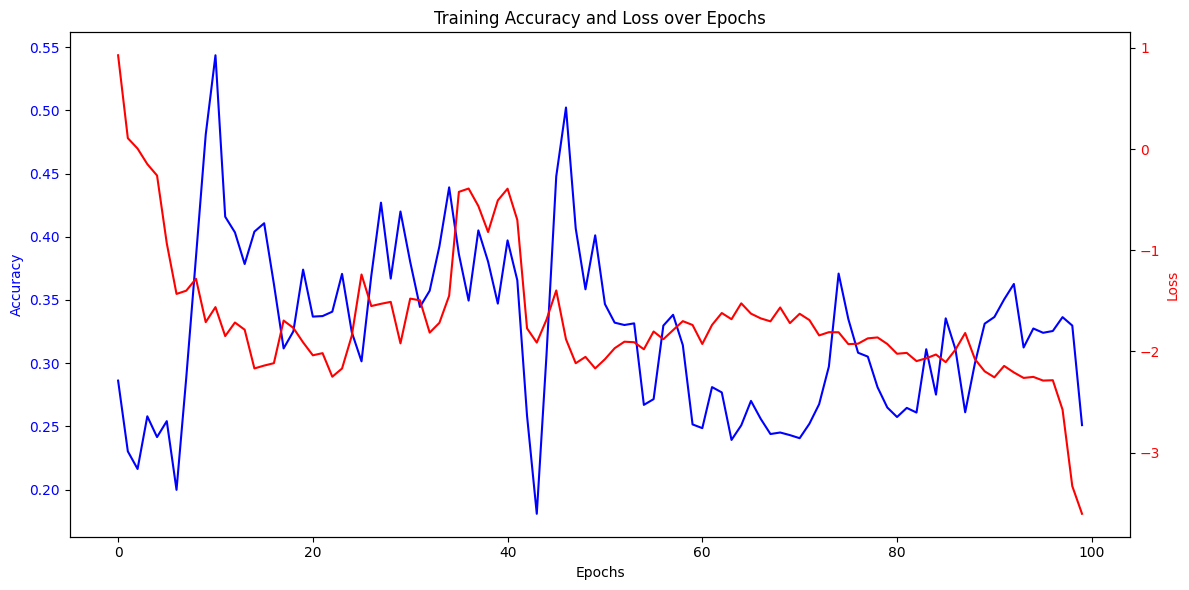

In [48]:
import matplotlib.pyplot as plt

fig, ax1 = plt.subplots(figsize=(12, 6))

ax1.plot(history.history['accuracy'], color='blue', label='Training Accuracy')
ax1.set_xlabel('Epochs')
ax1.set_ylabel('Accuracy', color='blue')
ax1.tick_params(axis='y', labelcolor='blue')

ax2 = ax1.twinx()
ax2.plot(history.history['loss'], color='red', label='Training Loss')
ax2.set_ylabel('Loss', color='red')
ax2.tick_params(axis='y', labelcolor='red')

plt.title('Training Accuracy and Loss over Epochs')
fig.tight_layout()
plt.show()

# **Avaliação do Modelo e Visualização de Resultados**

- Carrega o modelo salvo e o utiliza para prever as máscaras de segmentação em um conjunto de amostras de teste.
- Calcula a acurácia das predições e plota as imagens originais, as máscaras reais e as máscaras preditas lado a lado para comparação.

**Motivação**:
- A visualização das predições é essencial para entender o desempenho do modelo de segmentação em exemplos reais.
- A avaliação de acurácia fornece uma métrica quantitativa para a qualidade das predições.

In [49]:
TransferLearningModel = load_model('model_TL_UNET.keras')

1/1 [==============================] - 1s 601ms/step


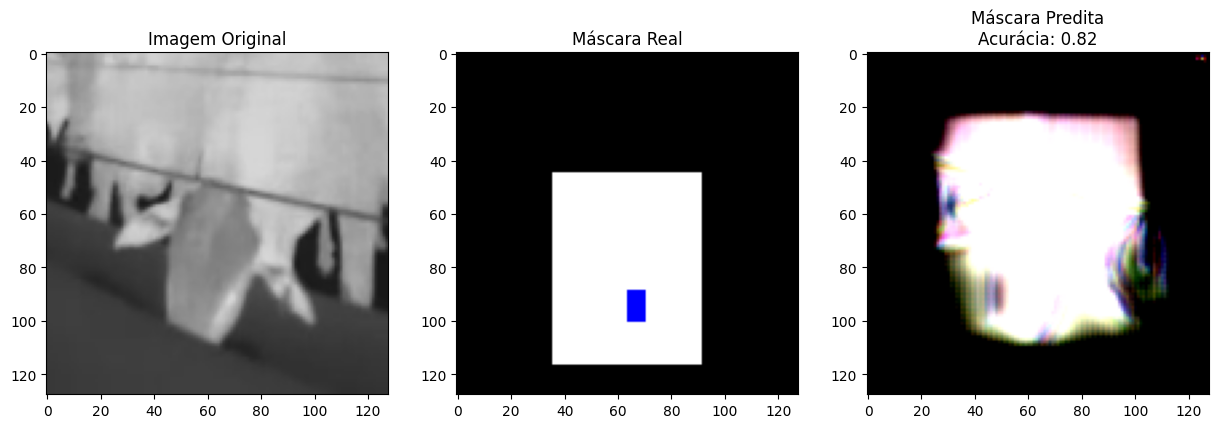

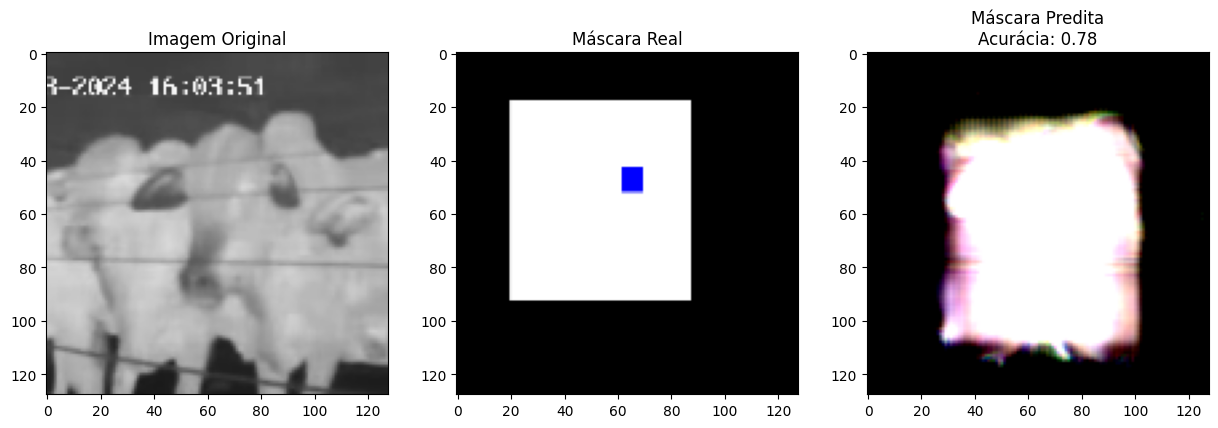

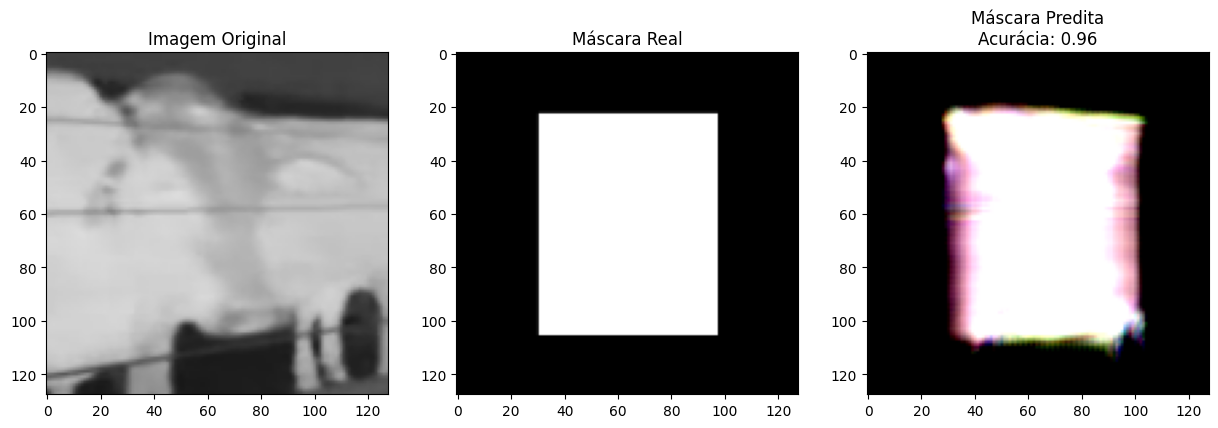

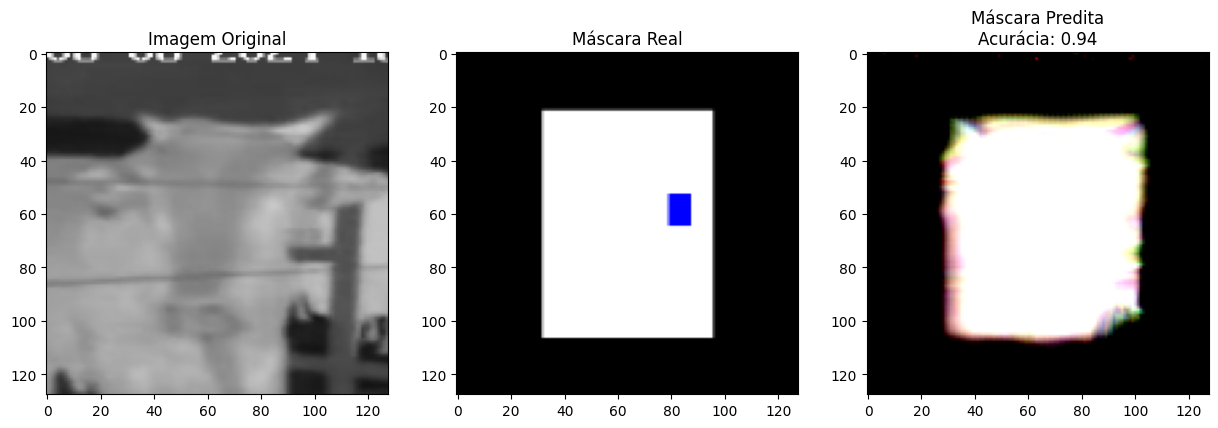

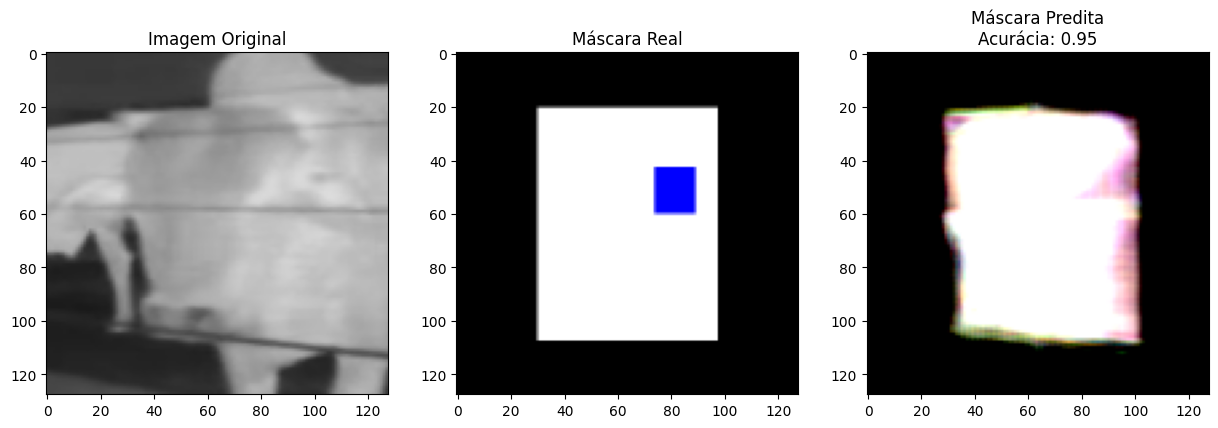

In [50]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score

# Choose a few samples to visualize (e.g., the first 5 samples)
num_samples = 5
sample_indices = np.arange(num_samples)

# Assuming X_ and y_ contain your input images and ground truth masks
X_samples = X_[sample_indices]
y_samples = y_[sample_indices]

# Get model predictions
predictions = TransferLearningModel.predict(X_samples)

# Plot the results
for i in range(num_samples):
    plt.figure(figsize=(15, 5))

    # Flatten the masks for accuracy calculation
    y_true_flat = y_samples[i].flatten()
    y_pred_flat = predictions[i].flatten()

    # Calculate accuracy
    acc = accuracy_score(y_true_flat > 0.5, y_pred_flat > 0.5)  # Binary threshold for accuracy

    # Plot the original image
    plt.subplot(1, 3, 1)
    plt.imshow(X_samples[i])
    plt.title('Imagem Original')

    # Plot the real mask
    plt.subplot(1, 3, 2)
    plt.imshow(y_samples[i], cmap='gray')
    plt.title('Máscara Real')

    # Plot the predicted mask
    plt.subplot(1, 3, 3)
    plt.imshow(predictions[i], cmap='gray')
    plt.title(f'Máscara Predita\nAcurácia: {acc:.2f}')

    plt.show()


# **Comparação de Treinamento entre CPU e GPU**

- Compara os tempos de treinamento e inferência entre a CPU e a GPU para avaliar o impacto da aceleração de hardware.
- Cria e treina modelos separados na CPU e na GPU, medindo o tempo necessário para cada processo.

**Motivação**:
- A comparação entre CPU e GPU ajuda a entender as vantagens de utilizar aceleração de hardware, especialmente em tarefas de deep learning que demandam grande poder computacional.
- Medir o tempo de inferência é importante para avaliar a eficiência do modelo em aplicações em tempo real.


In [ ]:

os.environ["CUDA_VISIBLE_DEVICES"] = "-1"

# Criar um novo modelo e treinar com a CPU
cpu_model = ModelEnhancer()
cpu_model.compile(optimizer=Adam(learning_rate=1e-3), loss=dice_loss, metrics=['accuracy'])
start_time = time.time()
cpu_history = cpu_model.fit(GenerateInputs(X_, y_), epochs=100, verbose=1, steps_per_epoch=5, shuffle=True)
end_time = time.time()
cpu_training_time = end_time - start_time

# Habilitar a GPU
os.environ["CUDA_VISIBLE_DEVICES"] = "0" 

# Criar um novo modelo e treinar com a GPU
gpu_model = ModelEnhancer()
gpu_model.compile(optimizer=Adam(learning_rate=1e-3), loss=dice_loss, metrics=['accuracy'])
start_time = time.time()
gpu_history = gpu_model.fit(GenerateInputs(X_, y_), epochs=100, verbose=1, steps_per_epoch=5, shuffle=True)
end_time = time.time()
gpu_training_time = end_time - start_time

# Comparar os tempos de treinamento
print(f"Tempo de treinamento da CPU: {cpu_training_time} segundos")
print(f"Tempo de treinamento da GPU: {gpu_training_time} segundos")

# Tempo de inferência da CPU
start_time = time.time()
cpu_predictions = cpu_model.predict(X_samples)
end_time = time.time()
cpu_inference_time = end_time - start_time

# Tempo de inferência da GPU
start_time = time.time()
gpu_predictions = gpu_model.predict(X_samples)
end_time = time.time()
gpu_inference_time = end_time - start_time

print(f"Tempo de inferência da CPU: {cpu_inference_time} segundos")
print(f"Tempo de inferência da GPU: {gpu_inference_time} segundos")